In [36]:
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Step 1: Import libraries
# (Already imported above)

# Step 2: List all .txt files in the folder with specific suffixes
folder_path = '/Users/joshuaingram/Main/Projects/SolarFlareNN/data/designaled/'  # Replace with your folder path
suffixes = ['_g18_bg', '_g17_bg', '_g16_bg']
dfs = {}

In [37]:
for suffix in suffixes:
    txt_files = [f for f in os.listdir(folder_path) if f.endswith(f"{suffix}.txt")]
    
    # Step 3: Read each .txt file into a DataFrame
    temp_dfs = []
    for txt_file in txt_files:
        file_path = os.path.join(folder_path, txt_file)
        df = pd.read_csv(file_path, header=None, delim_whitespace=True, names=['seconds_since_2000', f'designaled_flux{suffix}'])
        temp_dfs.append(df)
        
    # Step 4: Concatenate DataFrames with the same suffix
    dfs[suffix] = pd.concat(temp_dfs, ignore_index=True)

In [38]:
print(dfs)

{'_g18_bg':         seconds_since_2000  designaled_flux_g18_bg
0              729824880.0            3.803349e-10
1              729824940.0           -3.054056e-10
2              729825000.0            1.233390e-11
3              729825060.0            1.608860e-10
4              729825120.0           -2.969727e-10
...                    ...                     ...
485371         717908760.0           -1.472648e-08
485372         717908820.0           -2.991589e-09
485373         717908880.0           -1.117439e-08
485374         717908940.0           -5.590163e-09
485375         717909000.0            6.035308e-08

[485376 rows x 2 columns], '_g17_bg':          seconds_since_2000  designaled_flux_g17_bg
0               691611420.0           -4.404235e-10
1               691611480.0            1.153595e-09
2               691611540.0            9.142920e-10
3               691611600.0            1.311392e-09
4               691611660.0            4.080039e-09
...                     .

In [44]:
# Step 5: Sort each DataFrame by the date column
for suffix, df in dfs.items():
    dfs[suffix] = df.sort_values(by='seconds_since_2000')

# Step 6: Merge all DataFrames on 'date_seconds'
final_df = dfs['_g18_bg']
for suffix in ['_g17_bg', '_g16_bg']:
    final_df = pd.merge(final_df, dfs[suffix], on='seconds_since_2000', how='outer')

# Step 7: Convert the date column to date-time format
epoch_start = datetime(2000, 1, 1, 12)
final_df['date_time'] = final_df['seconds_since_2000'].apply(lambda x: epoch_start + timedelta(seconds=x))
final_df.sort_values(by='date_time', inplace=True)

# Step 8: Drop the 'date_seconds' column
final_df.drop('seconds_since_2000', axis=1, inplace=True)

# Step 9: Create new column that takes the flux from the satellite with the highest flux that is not missing
def max_flux(row):
    flux_values = [row[f'designaled_flux{suffix}'] for suffix in ['_g18_bg', '_g17_bg', '_g16_bg']]
    non_na_flux_values = [flux for flux in flux_values if not pd.isna(flux)]
    return max(non_na_flux_values) if non_na_flux_values else None

final_df['designaled_flux'] = final_df.apply(max_flux, axis=1)

# Step 10: Save the final DataFrame to a .csv file
final_df.to_csv('Goes161718_wavelet_designaled_flux.csv', index=False)

# Show the first few rows of the final DataFrame
print(final_df.head())

         designaled_flux_g18_bg  designaled_flux_g17_bg  \
4164291                     NaN                     NaN   
4164292                     NaN                     NaN   
4164293                     NaN                     NaN   
4164294                     NaN                     NaN   
4164295                     NaN                     NaN   

         designaled_flux_g16_bg           date_time  designaled_flux  
4164291            1.598873e-09 2017-02-07 00:00:00     1.598873e-09  
4164292            9.642111e-10 2017-02-07 00:01:00     9.642111e-10  
4164293           -2.792265e-09 2017-02-07 00:02:00    -2.792265e-09  
4164294            2.526616e-09 2017-02-07 00:03:00     2.526616e-09  
4164295            2.494040e-09 2017-02-07 00:04:00     2.494040e-09  


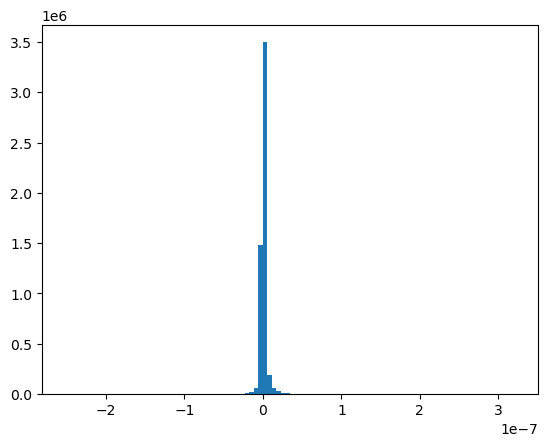

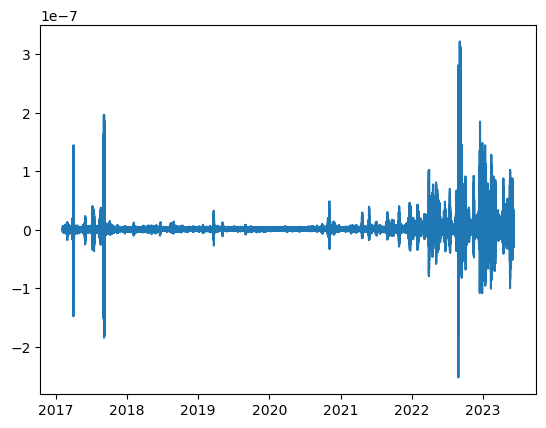

In [47]:
# plot distribution of flux values
plt.hist(final_df['designaled_flux'], bins=100)
plt.show()

# plot flux values over time
plt.plot(final_df['date_time'], final_df['designaled_flux'])
plt.show()